In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import itertools
from scipy.signal import savgol_filter
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter, laplace
from scipy import ndimage
#import cv2
from scipy import interpolate
from mpl_toolkits import mplot3d
from PIL import Image
%matplotlib inline
import IPython
import pickle
# from vtk.util import numpy_support
# import vtk
import pyvista as pv
import numpy as np
from scipy.interpolate import interpn

In [2]:
# jupyter nbconvert Jupyter\ Slides.ipynb --to slides --post serve

In [3]:
import plotly.graph_objects as go

In [4]:
def plot(traj_x,traj_y, traj_z, animation = True):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter3d(
            x=traj_x,
            y=traj_z,
            z=traj_y,
            mode='lines',
            line=dict(
                color='red',
                width = 7
            ),
            name='survey_interpolated'
        ),
    )
    fig.update_layout(scene = dict(
                  #  xaxis_title='X AXIS TITLE',
                    yaxis_title='Drilling direction',
                    zaxis_title='True vertical depth (TVD)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

    fig.update_scenes(zaxis_autorange="reversed")
    fig.show()
    

In [5]:
#plot(traj_x,traj_y, traj_z)

# Points

- увеличить окрестность рассмотрения

- добавить просчет окончания

## 3D dataset

In [6]:
all_candidates = []
items = [[-1,1], [-1, -1], [-1,0], [0,0], [0, -1], [0,1], [1,1], [1,0], [1,-1]]
for item in itertools.product(items, repeat=3):
            all_candidates.append(list(item))

In [7]:
# import 3d cube
file = open("3D_301.833.2055.pickle",'rb')
cube_3d = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '3D_301.833.2055.pickle'

In [ ]:
volume_cut= cube_3d[:,0::3,0::4]
volume_cut.shape

In [ ]:
# grid.spacing = (80/len(volume_cut[:,0,0]), 80/len(volume_cut[0,:,0]), 230/len(volume_cut[0,0,:]))

# Greedy algorithm for 3D resistivity space

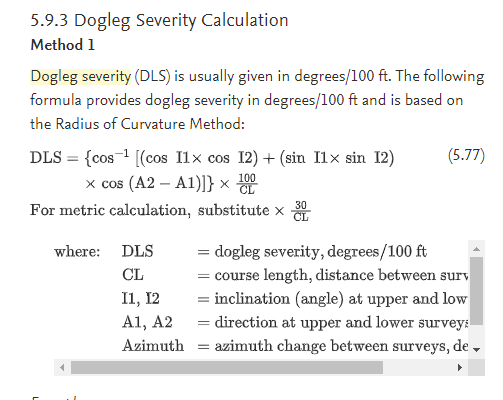

In [ ]:
class greedy_geosteering_advanced:
    def __init__(self, map_3d, items, step_z = 1, angle_constraint = 3, steps_ahead = 3, min_azimut = 0, max_azimut = 360,
                 min_zenith = 80, max_zenith = 91):
        
        self.map_3d = map_3d
        self.items = items
        self.step_z = step_z
        self.min_zenith = min_zenith
        self.max_zenith = max_zenith
        self.min_azimut = min_azimut
        self.max_azimut = max_azimut
        self.angle_constraint = angle_constraint
        self.steps_ahead = steps_ahead
        
    def get_dogleg(self, inc1, azi1, inc2, azi2):
        dogleg = (
        2 * np.arcsin(
            (
                np.sin((inc2 - inc1) / 2) ** 2
                + np.sin(inc1) * np.sin(inc2)
                * np.sin((azi2 - azi1) / 2) ** 2
            ) ** 0.5
        )
    )
        return dogleg
    
    def calc_dogleg(self, inc1, inc2, azi1, azi2):
        """
        Calculate dogleg between two points
        :param inc1: inclination at point 1
        :param inc2: inclination at point 2
        :param azi1: azimuth at point 1
        :param azi2: azimuth at point 2
        :return: dogleg in radians
        """

        if inc1 == inc2 and azi1 == azi2:
            dl = 0
        else:
            inner_value = np.cos(np.radians(inc1)) * np.cos(np.radians(inc2)) + np.sin(np.radians(inc1)) * np.sin(np.radians(inc2)) * \
                np.cos(np.radians(azi2 - azi1))
            if inner_value > 1:
                inner_value = 1
            if inner_value < -1:
                inner_value = -1
            dl = np.arccos(inner_value)
        return dl
    
    def _get_angles(self, traj_x, traj_y, traj_z):
        xz = traj_x ** 2 + traj_z ** 2
        inc = np.arctan2(np.sqrt(xz), traj_y)  # for elevation angle defined from y-axis down
        azi = (np.arctan2(traj_x, traj_z) + (2 * np.pi)) % (2 * np.pi)

        return np.stack((inc, azi), axis=1)
    
    def get_best_candidate(self, current_point):
        all_candidates = []
        
        for item in itertools.product(items, repeat = self.steps_ahead):
            all_candidates.append(list(item))
        
        best_candidate = all_candidates[0]
        cand_point = current_point
        OFV_best = 0

        dls = 0
                        
        if cand_point[0] < (self.map_3d.shape[0] - self.steps_ahead) and \
            (cand_point[1] < self.map_3d.shape[1] - self.steps_ahead) and (cand_point[2] < self.map_3d.shape[2] - self.step_z - self.steps_ahead):
                for l in range(0, len(all_candidates)):
                     #   obtain OFV of all possible candidates
                        OFV = 0
                        cand_point = current_point
                        cand_point_x = [current_point[0]]
                        cand_point_y = [current_point[1]]
                        cand_point_z = [current_point[2]]
                        dls = 0
                        for v in range(0, len(all_candidates[1])):

                            cand_point = [cand_point[0] + all_candidates[l][v][0] , 
                                          cand_point[1] + all_candidates[l][v][1], cand_point[2] + 1]
                            
                            cand_point_x.append(cand_point[0])
                            cand_point_y.append(cand_point[1])
                            cand_point_z.append(cand_point[2])
                            
                            cand_point_x_arr, cand_point_y_arr, cand_point_z_arr = np.array(cand_point_x),\
                            np.array(cand_point_y), np.array(cand_point_z)
                            if len(all_candidates[1]) > 1 and v > 1:
                                angles = self._get_angles(cand_point_x_arr, cand_point_y_arr, cand_point_z_arr)
                                incl1, az1 = angles[-1]
                                incl2, az2 = angles[-2]
                                dls = self.calc_dogleg(incl1, incl2, az1, az2)
                                
                                
                            if l == 0:
                                OFV_best += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]/ \
                                np.linalg.norm([cand_point_x, cand_point_y, cand_point_z]) - dls*10
                            else:
                                OFV += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]/ \
                                np.linalg.norm([cand_point_x, cand_point_y, cand_point_z]) - dls*10

                        if OFV > OFV_best:
                            best_candidate = all_candidates[l]
                            OFV_best = OFV
        return best_candidate
    
    def get_next_step(self, traj_x, traj_y, traj_z, z, dx = 0, dy = 0, step_back = 1):
        k = 0
        next_point = [traj_x[-1], traj_y[-1], traj_z[-1]]
        
        traj_x_array, traj_y_array, traj_z_array = np.stack([traj_x, traj_y, traj_z])
        angles = self._get_angles(traj_x_array, traj_y_array, traj_z_array)
        
        best_candidate = self.get_best_candidate(next_point)
        #  Calculate DogLeg
        if z >= step_back:
            incl1, az1 = angles[-1]
            incl2, az2 = angles[-step_back]
            
            dogleg = self.calc_dogleg(incl1, az1, incl2, az2)
            
            if np.degrees(dogleg) >= self.angle_constraint:
                next_step = [dx, dy, self.step_z]
                k = 1
            if (np.degrees(incl2) <= 80) or (np.degrees(incl2) >= 95):
                next_step = [0, 0, self.step_z]
                k = 1

            print(np.degrees(incl2), np.degrees(az2))
        if k != 1:
                #print("best_cand")
                next_step = [best_candidate[0][0], best_candidate[0][1], self.step_z]
                
        # upper boundary x,y constraint
        if next_point[0] >= self.map_3d.shape[0] - self.step_z:
            if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                next_step = [-self.step_x, - self.step_x, self.step_z]
            elif next_point[1] <= self.step_z:
                next_step = [-self.step_x, 0, self.step_z]
            else:
                next_step = [0, 0, self.step_z]
               
           
        # lower boundary x,x constraint
        if next_point[0] <= self.step_z:
            if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                next_step = [0, - self.step_x, self.step_z]
            elif next_point[1] <= self.step_z:
                next_step = [0, 0, self.step_z]
            else:
                next_step = [0, 0, self.step_z]
                    
                       
        # upper boundary y,x constraint
        if next_point[1] >= self.map_3d.shape[1] - self.step_z:       
            if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                next_step = [-self.step_x, - self.step_x, self.step_z] 
            else: 
                next_step = [0, - self.step_x, self.step_z]
                 
            # lower boundary y,x constraint
        if next_point[1] <= self.step_z:
            if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                next_step = [-self.step_x, 0, self.step_z]
            else:
                next_step = [0, 0, self.step_z]
                
        return next_step
                
            
    def traj_planning(self, start_point, step_back = 10):
        OFV = 0
        next_point = start_point
        traj_x = [start_point[0]]
        traj_y = [start_point[1]]
        traj_z = [start_point[2]]
        greedy_simple = False
        dx = 0
        dy = 0
        
        
        for z in range(0, self.map_3d.shape[2] - step_back, self.step_z):
            next_step = self.get_next_step(traj_x, traj_y, traj_z, dx = dx, dy = dy, z = z, step_back = step_back)
            
            next_point = [next_point[0] + next_step[0], next_point[1] + next_step[1], next_point[2] + next_step[2]] 
           
            
            
            
            
            if z > 0:
                dx = next_point[0] - next_point_prev[0] 
                dy = next_point[1] - next_point_prev[1]
            OFV += self.map_3d[next_point[0], next_point[1], next_point[2]]
            next_point_prev = next_point
            if z <= 10:
                
                traj_x.append(start_point[0])
                traj_y.append(start_point[1])
                traj_z.append(start_point[2] + 1)
            else:
                traj_x.append(next_point[0])
                traj_y.append(next_point[1])
                traj_z.append(next_point[2])
                
            
           
        print('OFV =', np.round(OFV, 2))
        return np.stack([traj_x, traj_y, traj_z])
    
    
    @staticmethod
    def trajectory_visualization(traj_x, traj_y, traj_z, color = 'red', width = 7):
        fig = go.Figure()

        fig.add_trace(
            go.Scatter3d(
                x=traj_x,
                y=traj_z,
                z=traj_y,
                mode='lines',
                line=dict(
                    color= color,
                    width= width
                ),
                name='survey_interpolated'
            ),
        )
        fig.update_layout(scene=dict(
            #  xaxis_title='X AXIS TITLE',
            yaxis_title='Drilling direction',
            zaxis_title='True vertical depth (TVD)'),
            width=700,
            margin=dict(r=20, b=10, l=10, t=10))

        fig.update_scenes(zaxis_autorange="reversed")
        fig.show()
        
        
        
    
    
    

In [ ]:
greedy_3d = greedy_geosteering_advanced(volume_cut, items = items, steps_ahead = 3, angle_constraint = 20, step_z = 1)

items = [[-1,1], [-1, -1], [-1,0], [0,0], [0, -1], [0,1], [1,1], [1,0], [1,-1]]
traj_x, traj_y, traj_z = greedy_3d.traj_planning(start_point = [140, 60, 0], step_back = 10)

In [ ]:
window_size = 140
traj_x_filtered = savgol_filter(traj_x, window_size, 3)
traj_y_filtered = savgol_filter(traj_y, window_size, 3)
traj_z_filtered = savgol_filter(traj_z, window_size, 3)

In [ ]:
traj_x_2 =  [traj_x[0], traj_x[100], traj_x[0]]
traj_y_2 =  [traj_y[0],traj_y[100], traj_y[0]]
traj_z_2 =  [traj_z[0],traj_z[100], traj_z[-1]]

In [ ]:
from matplotlib import transforms


x = []
z = []
y = []
property_along_y = []
property_along_x = []
for i in range(0,len(traj_x)):
    x.append(traj_x_filtered[i])
    z.append(traj_z_filtered[i])
    y.append(traj_y_filtered[i])
    property_along_y.append(volume_cut[traj_x[i],:,traj_z[i]].T)
    property_along_x.append(volume_cut[:,traj_y[i],traj_z[i]].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)
fig, ax = plt.subplots(1,1, figsize = (15,10))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
ax.plot(traj_z_filtered,traj_x_filtered, color = 'r', linewidth = 3, label = 'corrected'  )

ax.plot(traj_z_2,traj_x_2, color = 'b', linewidth = 3, label = 'initial' )
ax.set_title('YZ trajectory projection')
#ax[1].plot(z_t,y_t, color = 'r', linewidth = 3)
#ax[1].plot(z_t,y_t, color = 'r', linewidth = 3)
#ax[1].set_title('XZ trajectory projection')
ax.imshow(property_along_y_arr.T[::-1])
ax.legend()
#ax[1].imshow(property_along_x_arr.T[::-1])
p_map = ax.imshow(property_along_y_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)


ax.plot(traj_z_filtered,traj_y_filtered, color = 'r', linewidth = 3, label = 'corrected'  )
ax.plot(traj_z_2,traj_y_2, color = 'b', linewidth = 3, label = 'initial' )
ax.set_title('XZ trajectory projection')

ax.legend()
ax.imshow(property_along_x_arr.T[::-1])
p_map = ax.imshow(property_along_y_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)

In [ ]:
window_size = 32
traj_x_filtered = savgol_filter(traj_x, window_size, 3)
traj_y_filtered = savgol_filter(traj_y, window_size, 3)
traj_z_filtered = savgol_filter(traj_z, window_size, 3)

plot(traj_x_filtered, traj_y_filtered, traj_z_filtered)

$$r = argmax\int_a^b Sdr$$
$$\partial^2_{x_ix_j}S=\partial_{x_i}S_j$$

In [ ]:
class greedy_geosteering_polar:
    def __init__(self, map_3d, length = 12, angle_constraint_per_m = 0.1, steps_ahead = 7, start_point = [30,30,20],
                 init_inclination = 86, init_azimut = 0,
                 step_incl = 0.5, step_azi = 0.5,
                 min_azimut = 0, max_azimut = 270,
                 min_zenith = 70, max_zenith = 92):
        self.map_3d = map_3d
        
        self.length = length
        self.min_zenith = min_zenith
        self.max_zenith = max_zenith
        self.min_azimut = min_azimut
        self.max_azimut = max_azimut
        self.angle_constraint = angle_constraint_per_m
        self.steps_ahead = steps_ahead
        
        self.traj_x = [start_point[0]]
        self.traj_y = [start_point[1]]
        self.traj_z = [start_point[2]]
        
        self.incl_l = [init_inclination]
        self.azi_l = [init_azimut]
        
        self.step_incl = step_incl
        self.step_azimut = step_azi
        
        
        self.x = np.linspace(0, self.map_3d.shape[0] -1, self.map_3d.shape[0])
        self.y = np.linspace(0, self.map_3d.shape[1] -1, self.map_3d.shape[1])
        self.z = np.linspace(0, self.map_3d.shape[2] -1, self.map_3d.shape[2])
        self.points = (self.x, self.y, self.z)
    
    def get_vec(self, inc, azi, nev=False , deg=True):
        
        """
        Convert inc and azi into a vector.
        Params:
            inc: array of n floats
                Inclination relative to the z-axis (up)
            azi: array of n floats
                Azimuth relative to the y-axis
            r: float or array of n floats
                Scalar to return a scaled vector
        Returns:
            An (n,3) array of vectors
        """
        if deg:
            inc_rad, azi_rad = np.radians(np.array([inc, azi]))
        else:
            inc_rad = inc
            azi_rad = azi
        y = self.length * np.sin(inc_rad) * np.cos(azi_rad)
        x = self.length * np.sin(inc_rad) * np.sin(azi_rad)
        z = self.length * np.cos(inc_rad)

    #     if nev:
    #         vec = np.array([y, x, z]).T
    #     else:
    #         vec = np.array([x, y, z]).T
        return np.stack([x,y,z])


    def get_dogleg(self,inc1, azi1, inc2, azi2):
        
        inc1 = np.radians(inc1)
        inc2 = np.radians(inc2)
        azi1 = np.radians(azi1)
        azi2 = np.radians(azi2)
        dogleg = (
        2 * np.arcsin(
            (
                np.sin((inc2 - inc1) / 2) ** 2
                + np.sin(inc1) * np.sin(inc2)
                * np.sin((azi2 - azi1) / 2) ** 2
            ) ** 0.5
        )
    )
        return dogleg
    
    def get_best_candidate(self, current_point):
        OFV = 0
        OFV_best = 0
        all_candidates = []
        break_all = False
        items = [[-self.step_incl, self.step_azimut], [-self.step_incl, -self.step_azimut], [-self.step_incl, 0], [0,0], 
                 [0, -self.step_azimut], [0, self.step_azimut], 
                 [self.step_incl,self.step_azimut], [self.step_incl,0], [self.step_incl,-self.step_azimut]]
        
        for item in itertools.product(items, repeat = self.steps_ahead):
            all_candidates.append(list(item))
        
        best_candidate = all_candidates[0]
        cand_point = current_point
        OFV_best = 0
                        
        incl = self.incl_l[-1]
        azi = self.azi_l[-1]
     #   cand_point = [self.traj_x[-1],traj_y[-1], traj_z[-1]]
        for l in range(0, len(all_candidates)):
            OFV = 0
            cand_point = current_point
            for v in range(0, len(all_candidates[1])):
                incl += all_candidates[l][v][0]
                azi += all_candidates[l][v][1]
                incl_arr = np.array(incl)
                azi_arr = np.array(azi)

                vec = self.get_vec(incl_arr, azi_arr, self.length)
                cand_point = [cand_point[0] + vec[0],cand_point[1] + vec[1], cand_point[2] + vec[2]]           
                # interpolate between points
                try:
                    if l == 0:
                        OFV_best += interpn(self.points, self.map_3d, cand_point, method = 'nearest')/np.linalg.norm(vec)
                    else:
                        OFV +=  interpn(self.points, self.map_3d, cand_point, method = 'nearest')/np.linalg.norm(vec)
                except:
                    break_all = True
                                    
        if OFV > OFV_best:
            best_candidate = all_candidates[l]
            OFV_best = OFV

        return best_candidate, break_all
    
    
    def get_next_step(self,z, step_back = 1):
        k = 0
        next_point = [self.traj_x[-1], self.traj_y[-1], self.traj_z[-1]]
        traj_x_array, traj_y_array, traj_z_array = np.stack([traj_x, traj_y, traj_z])    
        best_candidate, break_all = self.get_best_candidate(next_point)
        OFV = 0
        break_al = False
        if z < 2:
            dogleg = 0
            next_incl_diff = best_candidate[0][0]
            next_azi_diff = best_candidate[0][1]
        else:   
            incl2 = self.incl_l[-1]
            azi2 = self.azi_l[-1]
            incl1 = self.incl_l[-1 - step_back]
            azi1 = self.azi_l[-1 - step_back]
       #     dogleg = self.get_dogleg(incl1, azi1, incl2, azi2)
          
    
            # limit zenith angle
            if incl2 >= self.max_zenith:
                next_incl_diff = - self.step_incl
            elif incl2 <= self.min_zenith:
                next_incl_diff = + self.step_incl
            else:
                next_incl_diff = best_candidate[0][0]
                
            # limith azimut angle
            if azi2 >= self.max_azimut:
                next_azi_diff = -self.step_azimut
            elif azi2 <= self.min_azimut:
                next_azi_diff = self.step_azimut
            else:
                next_azi_diff = best_candidate[0][1]
            
           # constraint dogleg severity
          #  if np.degrees(dogleg) >= self.angle_constraint:
            
            dls_val = np.linalg.norm(incl1 - incl2) + np.linalg.norm(azi1 - azi2)
            if dls_val >= self.angle_constraint * self.length:
                next_incl_diff = 0
                next_azi_diff = 0
            

           #  next_azi_diff = best_candidate[0][1]
              #  next_incl_diff = best_candidate[0][1]
        
        k = 0
       # print(next_azi_diff, next_incl_diff)
        if (next_point[0] >= self.map_3d.shape[0] - 30) or (next_point[0] <= 10):
            next_step = [0, 1, 0]
            k = 1
            break_al = True
        if (next_point[1] >= self.map_3d.shape[1] - 30) or (next_point[1] <= 10):
            next_step = [0, 1, 0]
            break_al = True
        if (next_point[2] >= self.map_3d.shape[2] - 30) or (next_point[2] <= 10):
            next_step = [0, 1, 0]
            break_al = True
                        
        if k == 1:
            vec_diff = next_step
        else:
            self.incl_l.append(self.incl_l[-1] + next_incl_diff)
            self.azi_l.append(self.azi_l[-1] + next_azi_diff)
            vec_diff = self.get_vec(self.incl_l[-1], self.azi_l[-1], self.length)

        self.traj_x.append(self.traj_x[-1] + vec_diff[0])
        self.traj_y.append(self.traj_y[-1] + vec_diff[1])
        self.traj_z.append(self.traj_z[-1] + vec_diff[2])
        point_new = np.array([self.traj_x[-1], self.traj_y[-1], self.traj_z[-1]])
        point_last = np.array([self.traj_x[-2], self.traj_y[-2], self.traj_z[-2]])
        
        OFV += interpn(self.points, self.map_3d, [self.traj_x[-1], self.traj_y[-1], self.traj_z[-1]], method = 'nearest') \
        /np.linalg.norm(point_new - point_last)
       # print(self.incl_l[-1],self.azi_l[-1], point_new, best_candidate)
        print(self.incl_l[-1], self.azi_l[-1], point_new)
        return OFV, break_al
    
    def traj_planning(self, step_back = 1):
        OFV = 0
        z = 1
        
        while self.traj_y[-1] <= self.map_3d.shape[1] - 1:
            OFV_p, break_al = self.get_next_step(z = z, step_back = step_back)
            
            OFV += OFV_p
            
            if break_al:
                break
            
            z += 1
        print('OFV =', np.round(OFV, 2))
        print(z)
        return np.stack([self.traj_x, self.traj_y, self.traj_z])
    
    def reset(self, start_point,init_inclination, init_azimut ):
        
        self.traj_x = [start_point[0]]
        self.traj_y = [start_point[1]]
        self.traj_z = [start_point[2]]
        
        self.incl_l = [init_inclination]
        self.azi_l = [init_azimut]
        
    

In [ ]:
# incl_l = [90]
# azi_l = [10]
# points = np.array([70,62,40])
# traj_x = [points[0]]
# traj_y = [points[1]]
# traj_z = [points[2]]
# points = (x, y, z)
# step_back = 1
# angle_constraint = 2
# OFV = 0
# z = 0
# OFV_best = 0


In [ ]:
d = greedy_geosteering_polar(volume_cut, length = 2, start_point = [110, 180, 20], init_inclination = 0, init_azimut = 90, 
                            min_zenith = -20, max_zenith = 20, angle_constraint_per_m = 10.5,
                            step_incl = 2, step_azi = 2)
traj_x, traj_y, traj_z = d.traj_planning()

In [ ]:
window_size = 11


traj_x_filtered = savgol_filter(traj_x, window_size, 3)
traj_y_filtered = savgol_filter(traj_y, window_size, 3)
traj_z_filtered = savgol_filter(traj_z, window_size, 3)

In [ ]:
plot(traj_x_filtered, traj_y_filtered, traj_z_filtered)

In [ ]:

x = []
z = []
y = []
property_along_y = []
property_along_x = []
property_along_z = []
for i in range(0,len(traj_x)):
    x.append(traj_x[i])
    z.append(traj_z[i])
    y.append(traj_y[i])
    property_along_y.append(volume_cut[round(traj_x[i]),:,round(traj_z[i])].T)
    property_along_x.append(volume_cut[:,round(traj_y[i]),round(traj_z[i])].T)
    property_along_z.append(volume_cut[round(traj_x[i]),round(traj_y[i]),:].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)
fig, ax = plt.subplots(1,1, figsize = (15,10))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
property_along_z_arr = np.array(property_along_z)
ax.plot(z_t,x_t, color = 'r', linewidth = 3 )
ax.set_title('ZX trajectory projection')


#ax.imshow(property_along_z_arr.T[::-1])

p_map = ax.imshow(property_along_y_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)

In [ ]:

x = []
z = []
y = []
property_along_y = []
property_along_x = []
property_along_z = []
for i in range(0,len(traj_x)):
    x.append(traj_x_filtered[i])
    z.append(traj_z_filtered[i])
    y.append(traj_y_filtered[i])
    property_along_y.append(volume_cut[round(traj_x[i]),:,round(traj_z[i])].T)
    property_along_x.append(volume_cut[:,round(traj_y[i]),round(traj_z[i])].T)
    property_along_z.append(volume_cut[round(traj_x[i]),round(traj_y[i]),:].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)
fig, ax = plt.subplots(2,1, figsize = (10,15))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
property_along_z_arr = np.array(property_along_z)
ax[0].plot(z_t,x_t, color = 'r', linewidth = 3, )
ax[0].set_title('YZ trajectory projection')
ax[1].plot(x_t,y_t, color = 'r', linewidth = 3)
ax[1].set_title('XZ trajectory projection')
ax[0].imshow(property_along_y_arr.T[::-1])
ax[1].imshow(property_along_x_arr.T[::-1])
p_map = ax[0].imshow(property_along_y_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

$$dI = (acos(\frac{y-yC}{dz})-i2)$$
$$dI_y = \frac{-1}{dz\sqrt{1-(\frac{y-yC}{dz})^2}}$$


$$dI = (acos(\frac{y-yC}{dz})-i2)$$
$$dI+i2 = acos(\frac{y-yC}{dz})$$
$$cos(dI+i2) = \frac{y-yC}{dz}$$
$$dzcos(dI+i2)+yC = y$$

In [ ]:
class Greedy_3d:
    def __init__(self, map_3d, n_steps_ahead, angle_constraint, step_z=1):
        self.map_3d = map_3d
        self.n_steps = n_steps_ahead
        self.angle_constraint = angle_constraint
        self.step_z = step_z
        self.step_x = 1
        self.step_y = 1

    def get_dogleg(self, inc1, azi1, inc2, azi2):
        dogleg = (
                2 * np.arcsin(
            (
                    np.sin((inc2 - inc1) / 2) ** 2
                    + np.sin(inc1) * np.sin(inc2)
                    * np.sin((azi2 - azi1) / 2) ** 2
            ) ** 0.5
        )
        )

        return dogleg

    def _get_angles(self, traj_x, traj_y, traj_z):
        xy = traj_x ** 2 + traj_y ** 2
        inc = np.arctan2(np.sqrt(xy), traj_z)  # for elevation angle defined from Z-axis down
        azi = (np.arctan2(traj_x, traj_y) + (2 * np.pi)) % (2 * np.pi)

        return np.stack((inc, azi), axis=1)

    def traj_planning(self, start_point, items, step_back=1):
        # traj = np.zeros_like(self.map_3d)

        # traj[start_point[0], start_point[1], start_point[2]] = 1
        OFV = 0
        k = 0
        next_point = start_point
        all_candidates = []
        traj_x = [start_point[0]]
        traj_y = [start_point[1]]
        traj_z = [start_point[2]]
        greedy_simple = False

        for item in itertools.product(items, repeat=self.n_steps):
            all_candidates.append(list(item))

        for z in range(0, self.map_3d.shape[2] - self.n_steps - start_point[2]):
            best_candidate = all_candidates[0]
            cand_point = next_point
            OFV_best = 0

            if cand_point[0] < (self.map_3d.shape[0] - self.n_steps) and \
                    (cand_point[1] < self.map_3d.shape[1] - self.n_steps):
                for l in range(0, len(all_candidates)):
                    #   obtain OFV of all possible candidates
                    OFV = 0
                    cand_point = next_point
                    for v in range(0, len(all_candidates[1])):

                        cand_point = [cand_point[0] + all_candidates[l][v][0],
                                      cand_point[1] + all_candidates[l][v][1], cand_point[2] + 1]
                        if l == 0:

                            OFV_best += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]
                        else:
                            OFV += self.map_3d[cand_point[0], cand_point[1], cand_point[2]]

                    if OFV > OFV_best:
                        best_candidate = all_candidates[l]
                        OFV_best = OFV
            # angle constraint based on dogleg severity
            # прирост углов между локальнымил линейными приближениями, нормированные по приросту длины

            # linear approximation

            #  Calculate DogLeg
            if z >= step_back + 2:
                #                 az1 = np.arccos((traj_x[-1] - traj_x[-2])/ self.step_z)
                #                 az2 = np.arccos((traj_x[-1 - step_back] - traj_x[-2 - step_back])/ self.step_z)
                #                 incl1 = np.arccos((traj_y[-1] - traj_y[-2])/ self.step_z)
                #                 incl2 = np.arccos((traj_y[-1 - step_back] - traj_y[-2 - step_back])/ self.step_z)

                #                 d_incl = (incl1 - incl2)
                #                 d_az = (az1 - az2)

                traj_x_array, traj_y_array, traj_z_array = np.stack([traj_x, traj_y, traj_z])

                angles = self._get_angles(traj_x_array, traj_y_array, traj_z_array)

                incl1, az1 = angles[-1]

                incl2, az2 = angles[-step_back - 1]

                print('dincl1', np.degrees(incl2-incl1), '\n daz', np.degrees(az2-az1))
                dogleg = self.get_dogleg(incl1, az1, incl2, az2)

#                 if np.degrees(dogleg) >= self.angle_constraint:
#                     next_step = [dx, dy, self.step_z]
#                     k = 1
            #     traj_y_targ = self.step_z*np.cos(self.angle_constraint+incl2)+traj_y[-2] #corrected y_target based on the restriction of dogleg
            # also possible is to do search on a half-sphere via the scipy optimize framework, but it needs to be restructured for your
            # problem (I had a distinct target endpoint)
            # here you could define the cost function based on your oil saturation
            # and regularise with softplus (ln(1+e^kx); smooth approximation of ReLU) of dogleg shifted to the maximum tolerance point

            if not greedy_simple and k != 1:
                next_step = [best_candidate[0][0], best_candidate[0][1], self.step_z]

            # upper boundary x,y constraint
            if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                    next_step = [-self.step_x, - self.step_x, self.step_z]
                elif next_point[1] <= self.step_z:
                    next_step = [-self.step_x, 0, self.step_z]
                else:
                    next_step = [0, 0, self.step_z]

                    # lower boundary x,x constraint
            if next_point[0] <= self.step_z:
                if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                    next_step = [0, - self.step_x, self.step_z]
                elif next_point[1] <= self.step_z:
                    next_step = [0, 0, self.step_z]
                else:
                    next_step = [0, 0, self.step_z]

                # upper boundary y,x constraint
            if next_point[1] >= self.map_3d.shape[1] - self.step_z:
                if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                    next_step = [-self.step_x, - self.step_x, self.step_z]
                else:
                    next_step = [0, - self.step_x, self.step_z]

                # lower boundary y,x constraint
            if next_point[1] <= self.step_z:
                if next_point[0] >= self.map_3d.shape[0] - self.step_z:
                    next_step = [-self.step_x, 0, self.step_z]
                else:
                    # next_point[0] <= self.step_z:
                    next_step = [0, 0, self.step_z]

            # print(next_point, next_step)

            next_point = [next_point[0] + next_step[0], next_point[1] + next_step[1], next_point[2] + next_step[2]]

            if z > 1:
                dx = next_point[0] - next_point_prev[0]
                dy = next_point[1] - next_point_prev[1]

            OFV += self.map_3d[next_point[0], next_point[1], next_point[2]]
            next_point_prev = next_point
            traj_x.append(next_point[0])
            traj_y.append(next_point[1])
            traj_z.append(next_point[2])

        print('OFV =', np.round(OFV, 2))
        return np.stack([traj_x, traj_y, traj_z])

    @staticmethod
    def trajectory_visualization(traj_x, traj_y, traj_z, color = 'red', width = 7):
        fig = go.Figure()

        fig.add_trace(
            go.Scatter3d(
                x=traj_x,
                y=traj_z,
                z=traj_y,
                mode='lines',
                line=dict(
                    color= color,
                    width= width
                ),
                name='survey_interpolated'
            ),
        )
        fig.update_layout(scene=dict(
            #  xaxis_title='X AXIS TITLE',
            yaxis_title='Drilling direction',
            zaxis_title='True vertical depth (TVD)'),
            width=700,
            margin=dict(r=20, b=10, l=10, t=10))

        fig.update_scenes(zaxis_autorange="reversed")
        fig.show()

In [ ]:
d = Greedy_3d(volume_cut, n_steps_ahead = 3, angle_constraint = 1)
traj_x, traj_y, traj_z = d.traj_planning(start_point = [140, 60, 10], items = items, step_back= 10)

In [ ]:
from welleng.connector import Connector
from welleng.survey import from_connections
from welleng.mesh import WellMesh
from welleng.visual import plot
# import os

# os.environ['DISPLAY'] = ':1'

# define start position and vector
pos1 = [0., 0., 0.]
vec1 = [0., 0., 1.]  # this is the same as inc=0, azi=0

# for the first section, we want to hold vertical for the first 500m
md2 = 500
vec2 = [0., 0., 1.]

# let's connect those points
s1 = Connector(
    pos1=pos1,
    vec1=vec1,
    md2=md2,
    vec2=vec2
)

# next we want to build to 30 degrees towards east
inc3 = 30
azi3 = 90

# let's connect this to the end of the previous section
# use the `_target` suffix to get the last position of the previous section
s2 = Connector(
    pos1=s1.pos_target,
    vec1=s1.vec_target,
    md1=s1.md_target,
    inc2=inc3,
    azi2=azi3
)

# the subsurface target has coordinates [-800, 300, 1800]
# we want to be near horizontal when we hit this point so that we can
# drill the reservoir horizontal (let's say 88 deg) and the reseroir
# orientation is southeast-northwest and we have good directional control
pos4 = [-800., 300., 1800.]
inc4 = 88
azi4 = 120
dls_design4 = 4

s3 = Connector(
    pos1=s2.pos_target,
    vec1=s2.vec_target,
    md1=s2.md_target,
    pos2=pos4,
    inc2=inc4,
    azi2=azi4,
    dls_design=dls_design4
)

# finally, we want a 500m horizontal section in the reservoir
md5 = s3.md_target + 500
inc5 = 90

s4 = Connector(
    pos1=s3.pos_target,
    vec1=s3.vec_target,
    md1=s3.md_target,
    md2=md5,
    inc2=inc5
)

# make a list of the well sections
well = [s1, s2, s3, s4]

# generate the survey listing and interpolate to get desired survey spacing
survey = from_connections(well, step=30)

# make a mesh
mesh = WellMesh(survey, method='circle')

In [ ]:
from welleng.connector import Connector
from welleng.survey import from_connections
from welleng.mesh import WellMesh
from welleng.visual import plot as weplots
# import os

# os.environ['DISPLAY'] = ':1'

# define start position and vector
pos1 = [0., 0., 0.]
vec1 = [0., 0., 1.]  # this is the same as inc=0, azi=0

# for the first section, we want to hold vertical for the first 500m
md2 = 500
vec2 = [0., 0., 1.]

# let's connect those points
s1 = Connector(
    pos1=pos1,
    vec1=vec1,
    md2=md2,
    vec2=vec2
)

# next we want to build to 30 degrees towards east
inc3 = 30
azi3 = 90

# let's connect this to the end of the previous section
# use the `_target` suffix to get the last position of the previous section
s2 = Connector(
    pos1=s1.pos_target,
    vec1=s1.vec_target,
    md1=s1.md_target,
    inc2=inc3,
    azi2=azi3
)

# the subsurface target has coordinates [-800, 300, 1800]
# we want to be near horizontal when we hit this point so that we can
# drill the reservoir horizontal (let's say 88 deg) and the reseroir
# orientation is southeast-northwest and we have good directional control
pos4 = [-800., 300., 1800.]
inc4 = 82
azi4 = 100
dls_design4 = 4

s3 = Connector(
    pos1=s2.pos_target,
    vec1=s2.vec_target,
    md1=s2.md_target,
    pos2=pos4,
    inc2=inc4,
    azi2=azi4,
    dls_design=dls_design4
)

# finally, we want a 500m horizontal section in the reservoir
md5 = s3.md_target + 500
inc5 = 90

s4 = Connector(
    pos1=s3.pos_target,
    vec1=s3.vec_target,
    md1=s3.md_target,
    md2=md5,
    inc2=inc5
)

# make a list of the well sections
well = [s1, s2, s3, s4]

# generate the survey listing and interpolate to get desired survey spacing
survey2 = from_connections(well, step=30)

# make a mesh
mesh2 = WellMesh(survey, method='circle')

In [ ]:
window_size = 42
traj_x_filtered = savgol_filter(traj_x, window_size, 3)
traj_y_filtered = savgol_filter(traj_y, window_size, 3)
traj_z_filtered = savgol_filter(traj_z, window_size, 3)
plot(traj_x_filtered, traj_y_filtered, traj_z_filtered)

In [ ]:
from matplotlib import transforms


x = []
z = []
y = []
property_along_y = []
property_along_x = []
for i in range(0,len(traj_x)):
    x.append(traj_x_filtered[i])
    z.append(traj_z_filtered[i])
    y.append(traj_y_filtered[i])
    property_along_y.append(volume_cut[traj_x[i],:,traj_z[i]].T)
    property_along_x.append(volume_cut[:,traj_y[i],traj_z[i]].T)


x_t = np.array(x)
z_t = np.array(z)
y_t = np.array(y)
fig, ax = plt.subplots(2,1, figsize = (10,15))
property_along_y_arr = np.array(property_along_y)
property_along_x_arr = np.array(property_along_x)
ax[0].plot(z_t,x_t, color = 'r', linewidth = 3, )
ax[0].set_title('YZ trajectory projection')
ax[1].plot(z_t,y_t, color = 'r', linewidth = 3)
ax[1].set_title('XZ trajectory projection')
ax[0].imshow(property_along_y_arr.T[::-1])
ax[1].imshow(property_along_x_arr.T[::-1])
p_map = ax[0].imshow(property_along_y_arr.T[::-1], aspect='auto')
plt.colorbar(p_map)